Financial Optimization Models Project

Name: Fendi Halim Tjoa & Yue Zhang



--------------------
we suggest running this notebook on Google Colab

## Import Libraries and upload csv file

In [1]:
#load 2008 stock price and shares.csv file as 2008 stock price and shares.csv
#this is the only file that needs to be loaded
from google.colab import files
uploaded = files.upload()

#This csv file contains the stock price and shares outstanding data. 
#It was downloaded from WRDS(Wharton Research Data Services) database
#with these data we can calculate stocks' market cap in the part "Calculate market portfolio weights for OCT 2008 and NOV 2008"

Saving 2008 stock price and shares.csv to 2008 stock price and shares.csv


In [5]:
!pip install cvxpy
import cvxpy as cp
import datetime # Package for making dates
import bs4 as bs
import pandas_datareader as web 
import numpy as np
import numpy.linalg as linalg
import pandas as pd

## Data Gathering
- Stock Price Data from Yahoo Finance
- Estimate Expected Returns
- Covariance Matrix

In [6]:
#Our investment universe consists of 20 stocks (n=20) all of which are con-
#stituents of the S&P 500. The stock symbols are
#F (Ford Motor Co.);CAT (Catepillar Inc.);DIS;MCD;KO; PEP;WMT;C;
#WFC; JPM ,AAPL; IBM; PFE; JNJ;XOM;MRO;ED; T; V Z; and NEM:

start = datetime.datetime(2004, 12, 30)
end = datetime.datetime(2008, 9, 30)
ticker_symbol = ['F','CAT','DIS','MCD','KO','PEP','WMT','C','WFC','JPM','AAPL','IBM','PFE','JNJ','XOM','MRO','ED','T','VZ','NEM']

n = len(ticker_symbol)
df_stock = web.DataReader(ticker_symbol, 'yahoo', start, end)

#month-end stock prices
monthly_prices = df_stock['Adj Close'].resample('M').ffill()

#calculate monthly returns based on stock prices
monthly_returns = df_stock['Adj Close'].resample('M').ffill().pct_change().iloc[1:,:]
monthly_log_returns = (np.log(df_stock['Adj Close'].resample('M').ffill()) - np.log(df_stock['Adj Close'].resample('M').ffill().shift(1))).iloc[1:,:]


In [7]:
#calculate expected returns
exp_returns=((monthly_returns+1).cumprod().iloc[-1])**(1/len(monthly_returns))-1
exp_returns

Symbols
F      -0.021158
CAT     0.006003
DIS     0.003179
MCD     0.016680
KO      0.007545
PEP     0.008628
WMT     0.004109
C      -0.015202
WFC     0.007098
JPM     0.006873
AAPL    0.028424
IBM     0.004888
PFE    -0.004837
JNJ     0.003931
XOM     0.010835
MRO     0.018531
ED      0.003832
T       0.005584
VZ     -0.000519
NEM    -0.002289
Name: 2008-09-30 00:00:00, dtype: float64

In [8]:
#calculate covariance matrix
monthly_returns.cov()

Symbols,F,CAT,DIS,MCD,KO,PEP,WMT,C,WFC,JPM,AAPL,IBM,PFE,JNJ,XOM,MRO,ED,T,VZ,NEM
Symbols,,,,,,,,,,,,,,,,,,,,
F,0.014721,0.001548,0.001057,0.002166,7.086874e-04,-0.000391,1.724197e-03,0.004618,0.001966,0.003574,0.001562,0.002104,0.001282,0.000321,0.002238,0.000780,0.001087,0.001222,0.001768,-0.000203
CAT,0.001548,0.004283,0.000862,0.001250,4.969156e-04,-0.000104,-1.611960e-04,0.000337,-0.000827,-0.000236,0.003675,0.000983,0.001181,-0.000261,0.001743,0.002795,0.000097,0.001910,0.001639,0.001442
DIS,0.001057,0.000862,0.001953,0.000913,5.041601e-04,0.000338,1.726771e-04,0.000499,-0.000515,-0.000423,0.001410,0.000938,0.000169,0.000273,0.000244,0.000657,0.000264,0.000797,0.000725,-0.001018
MCD,0.002166,0.001250,0.000913,0.002626,1.013901e-03,0.000560,1.547019e-04,0.001143,0.000282,0.000909,0.004075,0.001398,0.000633,0.000538,0.001275,0.001455,0.000758,0.001092,0.001138,0.000067
KO,0.000709,0.000497,0.000504,0.001014,1.234342e-03,0.000708,6.927632e-07,0.000575,0.000264,0.000730,0.001176,0.000475,0.000368,0.000519,0.000583,0.000352,0.000434,0.000777,0.000624,-0.000654
PEP,-0.000391,-0.000104,0.000338,0.000560,7.084121e-04,0.001304,-1.565357e-04,0.000575,0.000483,0.000724,0.000849,0.000035,0.000283,0.000677,-0.000149,-0.000256,0.000508,0.000373,0.000397,-0.001172
WMT,0.001724,-0.000161,0.000173,0.000155,6.927632e-07,-0.000157,1.959695e-03,0.000282,0.000560,0.000986,-0.000582,0.000463,-0.000710,0.000232,-0.000838,-0.001979,-0.000210,0.000028,0.000078,-0.001251
C,0.004618,0.000337,0.000499,0.001143,5.748997e-04,0.000575,2.816591e-04,0.006352,0.003721,0.004288,0.000854,0.000991,0.001176,0.000687,0.000538,-0.000697,0.000907,0.001081,0.001191,-0.001138
WFC,0.001966,-0.000827,-0.000515,0.000282,2.643581e-04,0.000483,5.599563e-04,0.003721,0.005304,0.004728,-0.002496,0.000556,0.001344,0.000434,-0.001066,-0.002649,0.000527,-0.000344,-0.000262,-0.001545


## (1) Mean-Variance Optimization Model (MVO)

*Note: short selling is allowed*

\begin{equation}
\begin{array}{rl}
\displaystyle \max_{w} & μ^Tx-λx^TQx \\
{\rm s.t.} & \sum_i x_i = 1\
\end{array}
\end{equation}

In [9]:
Q=np.array(monthly_returns.cov())
mu=np.array(exp_returns)

In [10]:
#define a function for MVO strategy, for later use
def MVO(Q, mu, lambd):
  x1 = cp.Variable(n)
  prob1 = cp.Problem(cp.Maximize(mu.T@x1-cp.quad_form(x1, Q)*lambd),
                   [sum(x1) == 1])
  prob1.solve()

  return(x1.value)

## (2) Robust mean-variance optimization

using ellipsoidal uncertainty set (assuming allow short selling)

\begin{equation}
\begin{array}{rl}
\displaystyle \max_{w} & μ^Tx-λx^TQx-ε_2\sqrt{x^TΘx} \\
{\rm s.t.} & \sum_i x_i = 1\
\end{array}
\end{equation}

In [11]:
T=len(monthly_returns)
theta = np.sqrt(np.diag(np.diag(Q))/T)

In [12]:
#define function for robust MVO strategy, for later use
def robustMVO(Q, mu, lambd, epsilon, theta):
  x2 = cp.Variable(n)
  prob2 = cp.Problem(cp.Maximize(mu.T@x2 - cp.quad_form(x2, Q)*lambd - cp.quad_form(x2, theta)*epsilon),
                   [sum(x2) == 1])
  prob2.solve()

  return(x2.value)


## (3) Risk Parity optimization without short selling

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & \sum_{i=1}^n (x_i(Qx)_i - θ)^2 \\
{\rm s.t.} & \sum_i x_i = 1\\
& x \geq 0
\end{array}
\end{equation}

In [13]:
from scipy.optimize import least_squares

def objectfunc(x):
    return np.array(x[0:20]*(Q@x[0:20])-x[20])
x0 = np.array([0.5]*20+[0])
res_1 = least_squares(objectfunc,x0,bounds=([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-np.inf],np.inf))
res_1.x

#The least_squares method doesn't take linear constraints, so we could only normalize the weights later to make sum of the weights equal to 1

array([0.3716791 , 0.73122826, 1.49015731, 0.65212738, 1.26992826,
       2.09229793, 3.2638698 , 0.56528032, 1.17018748, 0.65399253,
       0.347639  , 0.83363221, 0.90723129, 1.85108986, 0.80831557,
       0.73709856, 1.39217304, 0.76343239, 0.775522  , 1.87176269,
       0.01205107])

In [14]:
#normalize the result, so they sum up to 1
w_erc=res_1.x[0:20]/sum(res_1.x[0:20])
w_erc

array([0.01648343, 0.03242892, 0.06608633, 0.02892091, 0.05631949,
       0.09279041, 0.14474793, 0.02506937, 0.05189613, 0.02900363,
       0.01541729, 0.03697039, 0.0402344 , 0.08209318, 0.03584763,
       0.03268926, 0.06174087, 0.03385713, 0.03439329, 0.08300999])

In [15]:
#check risk contribution
var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
std_ERC = np.sqrt(var_ERC)
RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
RC_ERC

array([0.00108862, 0.00108862, 0.00108862, 0.00108862, 0.00108862,
       0.00108862, 0.00108862, 0.00108862, 0.00108862, 0.00108862,
       0.00108862, 0.00108862, 0.00108862, 0.00108862, 0.00108862,
       0.00108862, 0.00108862, 0.00108862, 0.00108862, 0.00108862])

## Calculate market portfolio weights for OCT 2008 and NOV 2008

In [16]:
import pandas as pd

df = pd.read_csv('2008 stock price and shares.csv')
#calculate market cap
df['Market Cap'] = df['PRC'] * df['SHROUT']
#calculate weights for OCT 2008
OCT_2008 = df[df['date']=='2008/10/31']
OCT_2008['weight'] = OCT_2008['Market Cap']/(OCT_2008['Market Cap'].sum())
#calculate weights for NOV 2008
NOV_2008 = df[df['date']=='2008/11/28']
NOV_2008['weight'] = NOV_2008['Market Cap']/(NOV_2008['Market Cap'].sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [17]:
OCT_2008['weight']

1     0.049306
5     0.005724
9     0.182378
13    0.060415
17    0.042828
21    0.046261
25    0.009931
29    0.011146
33    0.005624
37    0.057745
41    0.082913
45    0.002320
49    0.023517
53    0.054767
57    0.031514
61    0.074361
65    0.106198
69    0.040765
73    0.076306
77    0.035980
Name: weight, dtype: float64

In [18]:
NOV_2008['weight']

2     0.054111
6     0.005515
10    0.203444
14    0.054705
18    0.043944
22    0.041107
26    0.009218
30    0.012339
34    0.007413
38    0.055284
42    0.081106
46    0.003112
50    0.020801
54    0.053755
58    0.032675
62    0.058966
66    0.109698
70    0.046279
74    0.083986
78    0.022544
Name: weight, dtype: float64

In [19]:
#obtain price data for OCT and NOV 2008 to calculate actual return and variance

start_2008 = datetime.datetime(2008, 8, 28)
end_2008 = datetime.datetime(2008, 11, 30)
ticker_symbol = ['F','CAT','DIS','MCD','KO','PEP','WMT','C','WFC','JPM','AAPL','IBM','PFE','JNJ','XOM','MRO','ED','T','VZ','NEM']

df_stock_2008 = web.DataReader(ticker_symbol, 'yahoo', start_2008, end_2008)

#month returns of stock prices for OCT and NOV 2008
monthly_returns_2008 = df_stock_2008['Adj Close'].resample('M').ffill().pct_change().iloc[1:,:]

#variances
Q_2008_OCT = monthly_returns_2008.iloc[0:2].cov()
Q_2008_NOV = monthly_returns_2008.iloc[1:3].cov()

## OCT 2008

In [20]:
#average US treasury yield for OCT.2008 was 3.8072%
rf_OCT=3.8072/100

In [21]:
x_market = np.array(OCT_2008.set_index(['TICKER']).reindex(ticker_symbol)['weight'])
var_market = x_market@Q@x_market

#calculate risk aversion coefficient lambd based of the market portfolio
lambd_OCT = (mu@x_market-rf_OCT/12)/var_market
lambd_OCT 

3.820287489857026

In [27]:
x_robust_95

array([-0.14744091,  0.03298447,  0.04856003,  0.23709823,  0.10757195,
        0.18837919,  0.18505125, -0.23218316,  0.19165416,  0.1298586 ,
        0.07060673,  0.00603535, -0.13896701,  0.06315403,  0.1444613 ,
        0.12990687,  0.05180408,  0.03610414, -0.08741175, -0.01722755])

In [22]:
#set weights of the four portfolios as arries
x_mvo = MVO(Q, mu, lambd_OCT)
x_robust_95 = robustMVO(Q,mu, lambd_OCT, 1.96, theta)
x_robust_90 = robustMVO(Q,mu, lambd_OCT, 1.645, theta)
x_erc = w_erc.copy()
x_market = np.array(OCT_2008.set_index(['TICKER']).reindex(ticker_symbol)['weight']) 

return_mvo = monthly_returns_2008.iloc[1] @ x_mvo
return_robust_95 = monthly_returns_2008.iloc[1] @ x_robust_95
return_robust_90 = monthly_returns_2008.iloc[1] @ x_robust_90
return_erc = monthly_returns_2008.iloc[1] @ x_erc
return_market = monthly_returns_2008.iloc[1] @ x_market

var_mvo = x_mvo@Q@x_mvo
var_robust_95 = x_robust_95@Q@x_robust_95
var_robust_90 = x_robust_90@Q@x_robust_90
var_erc = x_erc@Q@x_erc
var_market = x_market@Q@x_market

result_OCT_2008 = pd.DataFrame({'Portfilio':['MVO', 'Robust MVO 95%','Robust MVO 90%', 'ERC', 'Market portfolio'], 
                       'return (monthly)':[return_mvo,return_robust_95,return_robust_90, return_erc,return_market],
                       'variance (monthly)':[var_mvo,var_robust_95,var_robust_90,var_erc,var_market],
                       'std (monthly)':[np.sqrt(var_mvo),np.sqrt(var_robust_95),np.sqrt(var_robust_90),np.sqrt(var_erc),np.sqrt(var_market)]})

result_OCT_2008['Sharpe ratio'] = (result_OCT_2008['return (monthly)']-rf_OCT/12)/result_OCT_2008['std (monthly)']

result_OCT_2008

,Portfilio,return (monthly),variance (monthly),std (monthly),Sharpe ratio
0,MVO,0.301588,0.009725,0.098614,3.026085
1,Robust MVO 95%,-0.003170,0.001435,0.037888,-0.167400
2,Robust MVO 90%,0.010379,0.001624,0.040295,0.178843
3,ERC,-0.145912,0.000474,0.021772,-6.847387
4,Market portfolio,-0.103685,0.000840,0.028974,-3.688004


## NOV 2008

In [23]:
#average US treasury yield for NOV.2008 was 3.521%
rf_NOV=3.521/100

In [24]:
x_market = np.array(NOV_2008.set_index(['TICKER']).reindex(ticker_symbol)['weight'])
var_market = x_market@Q@x_market

#calculate risk aversion coefficient lambd based of the market portfolio
lambd_NOV = (mu@x_market-rf_NOV/12)/var_market
lambd_NOV

4.493019828474735

In [25]:
#set weights of the four portfolios as arries
x_mvo = MVO(Q,mu,lambd_NOV)
x_robust_95 = robustMVO(Q, mu, lambd_NOV, 1.96,theta)
x_robust_90 = robustMVO(Q,mu, lambd_NOV, 1.645, theta)
x_erc = w_erc
x_market = np.array(NOV_2008.set_index(['TICKER']).reindex(ticker_symbol)['weight'])

return_mvo = monthly_returns_2008.iloc[2] @ x_mvo
return_robust_95 = monthly_returns_2008.iloc[2] @ x_robust_95
return_robust_90 = monthly_returns_2008.iloc[2] @ x_robust_90
return_erc = monthly_returns_2008.iloc[2] @ x_erc
return_market = monthly_returns_2008.iloc[2] @ x_market

var_mvo = x_mvo@Q@x_mvo
var_robust_95 = x_robust_95@Q@x_robust_95
var_robust_90 = x_robust_95@Q@x_robust_90
var_erc = x_erc@Q@x_erc
var_market = x_market@Q@x_market

result_NOV_2008 = pd.DataFrame({'Portfilio':['MVO', 'Robust MVO 95%','Robust MVO 90%', 'ERC', 'Market portfolio'], 
                       'return (monthly)':[return_mvo,return_robust_95,return_robust_90, return_erc,return_market],
                       'variance (monthly)':[var_mvo,var_robust_95,var_robust_90,var_erc,var_market],
                       'std (monthly)':[np.sqrt(var_mvo),np.sqrt(var_robust_95),np.sqrt(var_robust_90),np.sqrt(var_erc),np.sqrt(var_market)]})

result_NOV_2008['Sharpe ratio'] = (result_NOV_2008['return (monthly)']-rf_NOV/12)/result_NOV_2008['std (monthly)']

result_NOV_2008

,Portfilio,return (monthly),variance (monthly),std (monthly),Sharpe ratio
0,MVO,0.215702,0.007081,0.084149,2.528462
1,Robust MVO 95%,-0.009918,0.001248,0.035323,-0.363844
2,Robust MVO 90%,-0.007618,0.001318,0.036306,-0.290648
3,ERC,-0.008341,0.000474,0.021772,-0.517870
4,Market portfolio,-0.016005,0.000819,0.028615,-0.661860


## Plot efficient frontiers for MVO and robust MVO

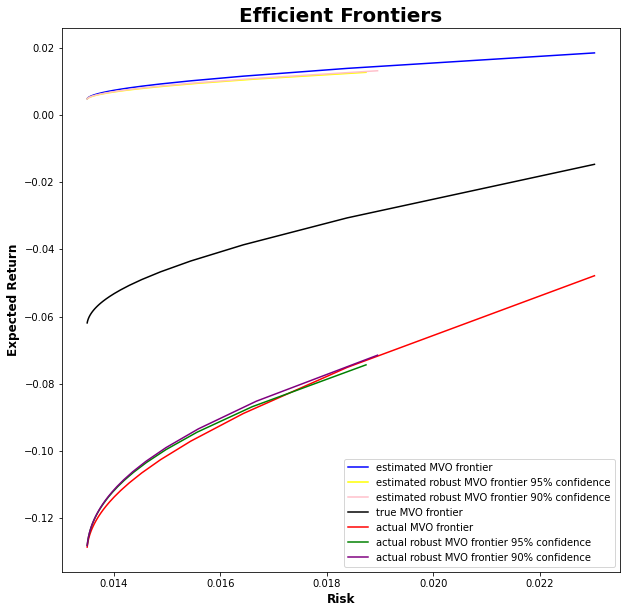

In [26]:
ret_MVO=[]
ret_MVO_actual=[]
ret_MVO_true=[]
var_MVO=[]
ret_robust_95=[]
ret_robust_actual_95=[]
var_robust_95=[]
ret_robust_90=[]
ret_robust_actual_90=[]
var_robust_90=[]

for lambd_i in np.linspace(1000,20,100):
  #calculate estimated portfolio return, actual portfolio return , true return and portfolio variances for MVO
  x_MVO=MVO(Q,mu,lambd_i)
  ret_MVO.append(mu@x_MVO)
  ret_MVO_actual.append(monthly_returns_2008.iloc[1]@x_MVO)
  var_MVO.append(x_MVO@Q@x_MVO)
  ret_MVO_true.append(((mu+monthly_returns_2008.iloc[1])/2)@x_MVO)
  
  #calculate estimated portfolio return, actual portfolio return and portfolio variances for 95% confident robust MVO
  x_robust = robustMVO(Q,mu,lambd_i, 1.96, theta)
  ret_robust_95.append(mu@x_robust)
  ret_robust_actual_95.append(monthly_returns_2008.iloc[1]@x_robust)
  var_robust_95.append(x_robust@Q@x_robust)

  #calculate estimated portfolio return, actual portfolio return and portfolio variances for 90% confident robust MVO
  x_robust = robustMVO(Q,mu,lambd_i, 1.645, theta)
  ret_robust_90.append(mu@x_robust)
  ret_robust_actual_90.append(monthly_returns_2008.iloc[1]@x_robust)
  var_robust_90.append(x_robust@Q@x_robust)

#Plot
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.title("Efficient Frontiers", fontweight = 'bold', fontsize=20)
plt.xlabel("Risk", fontweight = 'bold', fontsize=12)
plt.ylabel('Expected Return',fontweight = 'bold', fontsize=12)
ax = plt.gca()
# Plot efficient frontier
ax.plot(np.sqrt(var_MVO), ret_MVO, color='Blue', label='estimated MVO frontier')
ax.plot(np.sqrt(var_robust_95), ret_robust_95, color='yellow', label='estimated robust MVO frontier 95% confidence')
ax.plot(np.sqrt(var_robust_90), ret_robust_90, color='pink', label='estimated robust MVO frontier 90% confidence')
ax.plot(np.sqrt(var_MVO), ret_MVO_true, color='black', label='true MVO frontier')
ax.plot(np.sqrt(var_MVO), ret_MVO_actual, color='Red', label='actual MVO frontier')
ax.plot(np.sqrt(var_robust_95), ret_robust_actual_95, color='green', label='actual robust MVO frontier 95% confidence')
ax.plot(np.sqrt(var_robust_90), ret_robust_actual_90, color='purple', label='actual robust MVO frontier 90% confidence')
ax.legend()